# Linear Frequency Modulated (LFM) Impulses and their Spectrum

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/olddudealex/rf-notebooks/blob/main/pulse-modulation.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/olddudealex/rf-notebooks/blob/main/pulse-modulation.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/olddudealex/rf-notebooks/HEAD?labpath=pulse-modulation.ipynb)

To increase sensitivity and accuracy of radars it's quite common to use the frequency modulated impulses. In this article you can find short description of the simplest modulated impulse - Linear Frequency Modulated Impulse or Linear Chirp.

First of all let's do some math to get the right formula for Linear Chirp.

## LFM Impulse Phase

So let's see how we can represent the full phase for our linear modulated signal.

If the phase(!) is linear:

$$
\theta(t)=\omega_0 t+\phi=2\pi f_0 t+\phi
$$

$$
\omega_0=\frac{d}{d t} \theta(t)
$$

And if the phase is quadrature:
$$
\theta(t)=2 \pi a t^2+2 \pi f_0 t+\phi
$$
where $\alpha$-some constant

In this case instant angular frequency and ordinary frequency will be:
$$
\omega_i(t)=\frac{d}{d t} \theta(t)=4 \pi \alpha t+2 \pi f_0 \quad
$$
$$
f_i(t)=2 \alpha t+f_0 \quad
$$

Taking into account the fact that it is linear modulated impulse with impulse length $T$ we get:
$$
k=2 \alpha=\tan\gamma=\frac{f_1-f_0}{T}
$$
$$
\omega_i(t)=\frac{d}{d t} \theta(t)=2 \pi\left(k t+f_0\right)
$$

So get back to phase:
$$
\begin{aligned}
\theta(t) & =\int \omega_i(t) d t=2 \pi \int\left(k t+f_0\right) d t= \\
& =2 \pi\left(k \frac{t^2}{2}+f_0 t\right)+\phi_0 \\
& =\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t+\phi_0
\end{aligned}
$$
In future we will omit the initial phase $\phi_0$, because it has no impact on our results.

For our analysis we will use the FFT and we need to remember that this method has constraints and artifacts due to its discrete nature.

Ok, let's start with simple CW of 3GHz, the time units that we will have in discrete world set equal to 1ps.

FFT Bin Size=1.00Mhz


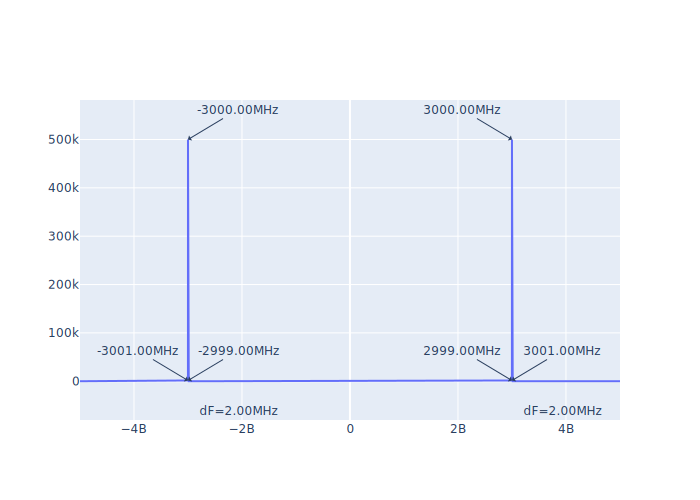

In [1]:
import plotly.io as pio

# The next line is a special one for auto-generation of static page version.
static_rendering = True
if static_rendering:
  pio.renderers.default = "svg"
elif 'google.colab' in str(get_ipython()):
  %cd /content
  !rm -rf rf-notebooks
  !git clone -q -s https://github.com/olddudealex/rf-notebooks/ rf-notebooks
  %cd rf-notebooks
  pio.renderers.default = "colab"
  print("The colab renderer is used")
else:
  pio.renderers.default = "plotly_mimetype+notebook"
  print("The notebook renderer is used")

import plot_data as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initial parameters
f0 = 3 * (10**9)                # central freq of CW  3GHz
delta_f = 0                     # max - min freq diff 0MHz
tu = 1*10**(-12)                # time units (time resolution) 1ps
fs = 1/tu                       # sampling freq of simulation

L_sec = 1000 * (10**(-9))       # length of impulse   1000ns
s_sec = 0 * (10**(-9))          # start of impulse    0ns
sim_dur = 1000 * (10**(-9))     # simulation duration 1000ns
N = sim_dur / tu                # amount of samples
f_res = fs / N                  # FFT bin size

L = int(L_sec/tu)               # length of impulse in time units
s = int(s_sec/tu)               # start of impulse in time units
e = s + L                       # end of simulation

t = np.arange(0, sim_dur, tu)

print(f"FFT Bin Size={f_res/1000000:.2f}Mhz")

# create the impulse
rf = np.zeros(t.shape)
k = delta_f / (t[e] - t[s])
rf[s:e] = (np.cos(2 * np.pi
                    * (f0 - delta_f / 2 + k * t[s:e] / 2)
                    * t[s:e]))

data = pd.PlotData(rf, fs)
data.trim_freq(-5 * 10**9, 5 * 10**9)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x, y=data.freq_domain, name='RF CW spectrum'),
              row=1, col=1)
pd.mark_peaks(fig, data, row=1, col=1)
pd.mark_bands(fig, data, row=1, col=1)

fig.update_layout(hovermode='x unified', height=500)
fig.show()

You can see that the FFT bin size is now equal to 1Mhz, this is our resolution that is defined by sampling frequency and amount of samples. Ok, with this resolution we can see that the spectrum is symmetrical (the signal is real) and the band is very narrow (it's only one frequency bin). What will be if we apply the modulation from -50 to 50 Mhz? Will be the spectrum bands be equal to 100Mhz? Let's try! Now and further I will hide the most of code to generate the signals, you always can find the details by inspecting other source files.

FFT Bin Size=0.10Mhz


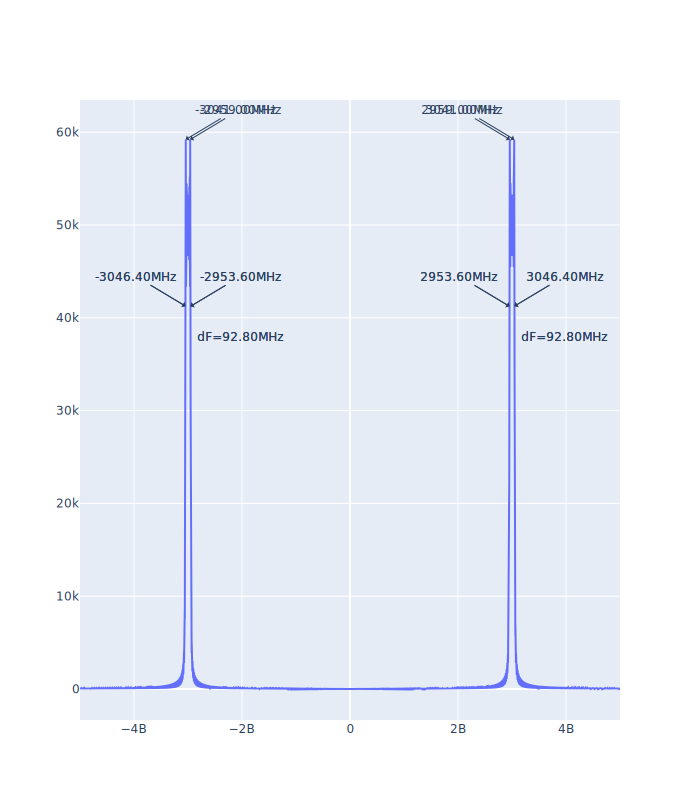

In [2]:
rf = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))

print(f"FFT Bin Size={rf.sig.f_res/1000000:.2f}Mhz")

data = pd.PlotData(rf.sig.data, rf.sig.fs)
data.trim_freq(-5 * 10 ** 9, 5 * 10 ** 9)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.freq_domain_x,
                         y=data.freq_domain,
                         name='RF modulated impulse spectrum'),
              row=1, col=1)
peaks = data.freq_peaks
pd.mark_peaks(fig, data, row=1, col=1)
pd.mark_bands(fig, data, row=1, col=1)

fig.update_layout(hovermode='x unified', height=800)
fig.show()

Ok, the width of 92.8Mhz defined by -3dB level relative to maximum spikes is quite close to our expectation.

## LFM Impulse Spectrum
Our non-modulated real signal can be represented by a cos function:
$$
    s(t)=A\cos(2 \pi f_0 t)=A\cos(\omega_0 t)
$$
And in general case FM or PM signal will be:
$$
    s(t)=A\cos[\theta(t)]
$$
According to Euler formula:
$$
    cos(x)=Re(e^{jx})=\frac{e^{jx} - e^{-jx}}{2}
$$
These two terms correspond to two symmetrical with respect to zero peaks in frequency domain. You could think about this equation in a following manner. If we want to oscillate only along the Real axis on a complex circle, we have to sum two complex signals that are rotating synchronically in two opposite directions: clockwise and conterclockwise.  
Now, let's for simplicity focus only on one term further. So, after all we are looking at the signal:
$$
    s_1(t)=\frac{1}{2}e^{jx}=\frac{1}{2}exp[j\,x]
$$
And if we take into account our linear frequency modulated phase equation we get:
$$
    s_1(t)=\frac{1}{2}exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t)]
$$


The signal in Frequency domain could be get by Fourier transform:
$$
    S(\omega)=\int_{-\infty}^\infty s(t) \cdot exp(-j \omega t) \,dt
$$
$$
    S_1(\omega)= \frac{1}{2} \int_{-\infty}^\infty exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2}+\omega_0 t)] \cdot exp(-j \omega t) \,dt
$$
$$
    S_1(\omega)=\frac{1}{2} \int_{-\infty}^\infty exp[j (\frac{\Delta \omega}{T} \cdot \frac{t^2}{2} + (\omega_0 - \omega) t))] \,dt
$$
This is quite cumbersome integral, but it has analytical solution with the help of Fresnel signals (please google it, if you are interested).  
The very final results after the solution of this signal is that the form of spectrum highly depends on the time-bandwidth product of the chirp $T\cdot \Delta f$.

## Time-Bandwidth Product Impact
Let's take several chirp impulses with different $T \cdot \Delta f$ parameters and see what is their spectrum. Here and below I'm using the modulated impulses of 1uS length with 4 different sweep frequency range. Also, I will be focusing only on the positive spectrum band. The negative part will be symmetrical to positive for real signals anyway, so I will omit it.

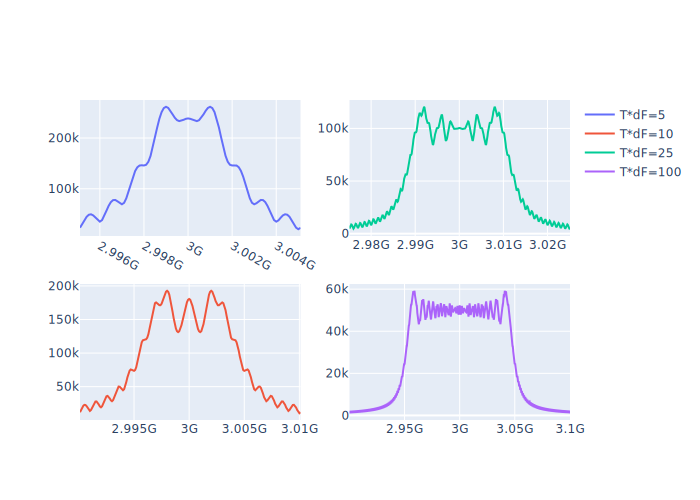

In [3]:
s1 = pd.LfmSignal(f0=3*(10**9), delta_f=5*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
s2 = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
s3 = pd.LfmSignal(f0=3*(10**9), delta_f=25*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
s4 = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                  l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))

data1 = pd.PlotData(s1.sig.data, s1.sig.fs)
data1.trim_freq(s1.f0 - s1.delta_f, s1.f0 + s1.delta_f)
data2 = pd.PlotData(s2.sig.data, s2.sig.fs)
data2.trim_freq(s2.f0 - s2.delta_f, s2.f0 + s2.delta_f)
data3 = pd.PlotData(s3.sig.data, s3.sig.fs)
data3.trim_freq(s3.f0 - s3.delta_f, s3.f0 + s3.delta_f)
data4 = pd.PlotData(s4.sig.data, s4.sig.fs)
data4.trim_freq(s4.f0 - s4.delta_f, s4.f0 + s4.delta_f)

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=data1.freq_domain_x,
                         y=data1.freq_domain,
                         name=f"T*dF={s1.L_sec*s1.delta_f:0.0f}"), row=1, col=1)
fig.add_trace(go.Scatter(x=data2.freq_domain_x,
                         y=data2.freq_domain,
                         name=f"T*dF={s2.L_sec*s2.delta_f:0.0f}"), row=2, col=1)
fig.add_trace(go.Scatter(x=data3.freq_domain_x,
                         y=data3.freq_domain,
                         name=f"T*dF={s3.L_sec*s3.delta_f:0.0f}"), row=1, col=2)
fig.add_trace(go.Scatter(x=data4.freq_domain_x,
                         y=data4.freq_domain,
                         name=f"T*dF={s4.L_sec*s4.delta_f:0.0f}"), row=2, col=2)

fig.update_layout(hovermode='x unified', height=500)
fig.update_xaxes(exponentformat="SI")
fig.show()

**The scale is different for different subplots!**  
You can see now how the LFM signal spectrum depends on the product $T \cdot \Delta F$. The amount of energy that is kept outside of the min to max LFM band slightly varies. We can show it more explicitly below:

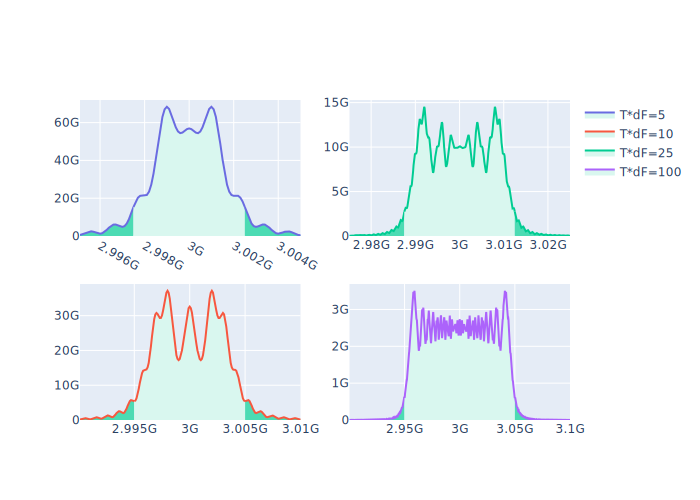

For T*dF=5  Pout/Pin=9.73%
For T*dF=10  Pout/Pin=7.12%
For T*dF=25  Pout/Pin=4.44%
For T*dF=100  Pout/Pin=2.24%


In [4]:
def plot_freq_band(signals: list[pd.LfmSignal], plot_data: list[pd.PlotData]):
      separated_data = []
      for i, s in enumerate(signals):
            separated_data.append(plot_data[i].separate_by_freq_points([s.f0 - s.delta_f, s.f1-100000, s.f2-100000, s.f0 + s.delta_f]))

      def add_band_trace(fig, row, col, data, line_color, legend):
            fig.add_trace(go.Scatter(x=data[0].freq_domain_x,
                                    y=np.power(data[0].freq_domain, 2),
                                    line_color=line_color,
                                    fill="tozeroy",
                                    fillcolor="#4CDBB3",
                                    showlegend=False), row=row, col=col)
            
            fig.add_trace(go.Scatter(x=data[1].freq_domain_x,
                                    y=np.power(data[1].freq_domain, 2),
                                    line_color=line_color,
                                    fill="tozeroy",
                                    fillcolor="#D9F7EF",
                                    name=legend), row=row, col=col)
            
            fig.add_trace(go.Scatter(x=data[2].freq_domain_x,
                                    y=np.power(data[2].freq_domain, 2),
                                    line_color=line_color,
                                    fill="tozeroy",
                                    fillcolor="#4CDBB3",
                                    showlegend=False), row=row, col=col)


      fig = make_subplots(rows=2, cols=2)
      add_band_trace(fig, 1, 1, separated_data[0], "#6A6BE1", f"T*dF={signals[0].L_sec*signals[0].delta_f:0.0f}")
      add_band_trace(fig, 2, 1, separated_data[1], "#F7573F", f"T*dF={signals[1].L_sec*signals[1].delta_f:0.0f}")
      add_band_trace(fig, 1, 2, separated_data[2], "#00CC92", f"T*dF={signals[2].L_sec*signals[2].delta_f:0.0f}")
      add_band_trace(fig, 2, 2, separated_data[3], "#AC63FB", f"T*dF={signals[3].L_sec*signals[3].delta_f:0.0f}")

      fig.update_layout(hovermode='x unified', height=500)
      fig.update_xaxes(exponentformat="SI")
      fig.update_yaxes(exponentformat="SI")
      fig.show()

      def power_relation(data: list[pd.PlotData]):
            return 2 * np.sum(np.power(data[0].freq_domain, 2)) / np.sum(np.power(data[1].freq_domain, 2))

      for i, s in enumerate(signals):
            print(f"For T*dF={s.L_sec*s.delta_f:0.0f}  Pout/Pin="f"{100 * power_relation(separated_data[i]) :.2f}%")

plot_freq_band([s1, s2, s3, s4], [data1, data2, data3, data4])

The amount of energy inside the range between start and end frequencies of LFM (we can call it sweep range, this is green areas in the graphs) to outside (blue area) is different. The more the product $T \cdot \Delta f$ is, the more energy is kept inside the sweep range of LFM signal. But it's rather small amount of energy: for $T \cdot \Delta f = 10$ it's around 7%, for 25 - less than 5%. These results match to the data from Wiki.

But much more often RF engineers use the logarithmic scale, it allows to see better the details of signal with high amplitude difference. So, lets see the same data in logarithmic scale:

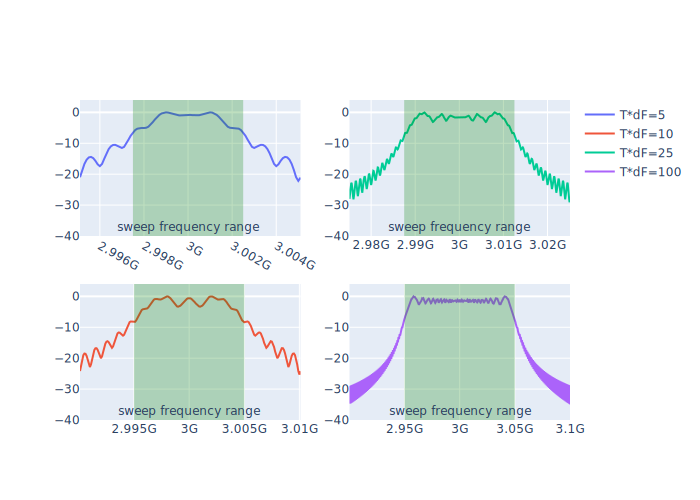

In [5]:
def plot_freq_band_log(s: list[pd.LfmSignal], data: list[pd.PlotData], range: list):
    def log_scale(data: pd.PlotData):
        ref = data.freq_domain[data.freq_peaks[0]]
        return 20 * np.log10(data.freq_domain / ref)

    fig = make_subplots(rows=2, cols=2)
    fig.add_trace(go.Scatter(x=data[0].freq_domain_x,
                            y=log_scale(data[0]),
                            name=f"T*dF={s[0].L_sec*s[0].delta_f:0.0f}"), row=1, col=1)
    fig.add_trace(go.Scatter(x=data[1].freq_domain_x,
                            y=log_scale(data[1]),
                            name=f"T*dF={s[1].L_sec*s[1].delta_f:0.0f}"), row=2, col=1)
    fig.add_trace(go.Scatter(x=data[2].freq_domain_x,
                            y=log_scale(data[2]),
                            name=f"T*dF={s[2].L_sec*s[2].delta_f:0.0f}"), row=1, col=2)
    fig.add_trace(go.Scatter(x=data[3].freq_domain_x,
                            y=log_scale(data[3]),
                            name=f"T*dF={s[3].L_sec*s[3].delta_f:0.0f}"), row=2, col=2)

    fig.add_vrect(x0=s[0].f1, x1=s[0].f2, row=1, col=1,
                annotation_text="sweep frequency range", annotation_position="bottom",
                fillcolor="green", opacity=0.25, line_width=0)

    fig.add_vrect(x0=s[1].f1, x1=s[1].f2, row=2, col=1,
                annotation_text="sweep frequency range", annotation_position="bottom",
                fillcolor="green", opacity=0.25, line_width=0)

    fig.add_vrect(x0=s[2].f1, x1=s[2].f2, row=1, col=2,
                annotation_text="sweep frequency range", annotation_position="bottom",
                fillcolor="green", opacity=0.25, line_width=0)

    fig.add_vrect(x0=s[3].f1, x1=s[3].f2, row=2, col=2,
                annotation_text="sweep frequency range", annotation_position="bottom",
                fillcolor="green", opacity=0.25, line_width=0)

    fig.update_yaxes(range = range)
    fig.update_xaxes(exponentformat="SI")
    fig.update_layout(hovermode='x unified', height=500)

    fig.show()

plot_freq_band_log([s1, s2, s3, s4], [data1, data2, data3, data4], [-40, 4])

It's quite interesting that the spectrum crosses the sweep frequency range at the level about -10dB for all the values of T*dF product. But the curves slopes are different. What options do you have if you are not satisfied with the signal spectrum and want it to be narrower? For example, to reduce the interference between adjacent channels? Wiki recommends to use amplitude weighting, for example Hamming window. Let's try it!

## Hamming Window Weighting of the Chirp

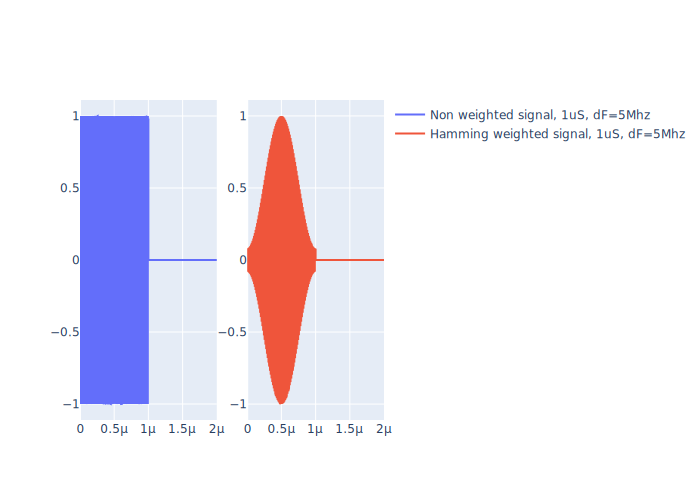

In [6]:
sh1 = pd.LfmSignal(f0=3*(10**9), delta_f=5*(10**6), tu=10**(-12),
                   l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
sh2 = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=10**(-12),
                   l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
sh3 = pd.LfmSignal(f0=3*(10**9), delta_f=25*(10**6), tu=10**(-12),
                   l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))
sh4 = pd.LfmSignal(f0=3*(10**9), delta_f=100*(10**6), tu=10**(-12),
                   l_sec=1000*(10**(-9)), s_sec=0, sim_dur=10000*(10**(-9)))

# The impulse is kept in first L samples of s.sig.data.
sh1.sig.data[:L] = np.hamming(sh1.L) * sh1.sig.data[:L]
sh2.sig.data[:L] = np.hamming(sh2.L) * sh2.sig.data[:L]
sh3.sig.data[:L] = np.hamming(sh3.L) * sh3.sig.data[:L]
sh4.sig.data[:L] = np.hamming(sh4.L) * sh4.sig.data[:L]

datah1 = pd.PlotData(sh1.sig.data, sh1.sig.fs)
datah1.trim_freq(sh1.f0 - sh1.delta_f, sh1.f0 + sh1.delta_f)
datah2 = pd.PlotData(sh2.sig.data, sh2.sig.fs)
datah2.trim_freq(sh2.f0 - sh2.delta_f, sh2.f0 + sh2.delta_f)
datah3 = pd.PlotData(sh3.sig.data, sh3.sig.fs)
datah3.trim_freq(sh3.f0 - sh3.delta_f, sh3.f0 + sh3.delta_f)
datah4 = pd.PlotData(sh4.sig.data, sh4.sig.fs)
datah4.trim_freq(sh4.f0 - sh4.delta_f, sh4.f0 + sh4.delta_f)

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=data1.time_domain_x[:s1.L*2:10],
                         y=data1.time_domain[:s1.L*2:10],
                         name=f"Non weighted signal, 1uS, dF={s1.delta_f/1000000:0.0f}Mhz"), row=1, col=1)
fig.add_trace(go.Scatter(x=datah1.time_domain_x[:sh1.L*2:10],
                         y=datah1.time_domain[:sh1.L*2:10],
                         name=f"Hamming weighted signal, 1uS, dF={sh1.delta_f/1000000:0.0f}Mhz"), row=1, col=2)

fig.update_layout(hovermode='x unified', height=500)
fig.update_xaxes(exponentformat="SI")
fig.show()

That's how Hamming windowing looks like in time domain. Now let's see the spectrum of Hamming weighted signals:

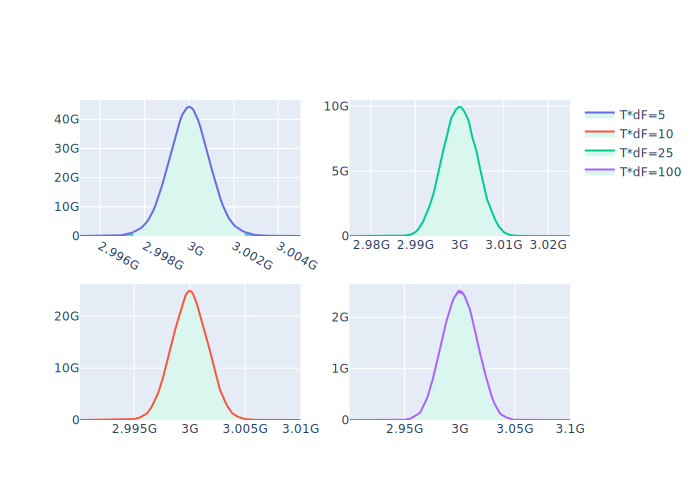

For T*dF=5  Pout/Pin=1.15%
For T*dF=10  Pout/Pin=0.23%
For T*dF=25  Pout/Pin=0.07%
For T*dF=100  Pout/Pin=0.03%


In [7]:
plot_freq_band([sh1, sh2, sh3, sh4], [datah1, datah2, datah3, datah4])

That's a fascinating result, it doesn't look even similar to the spectrums without Hamming windowing! Let's plot 2 other views of power and log scale power of these spectrums and calculate the relation of powers outside and inside a band.

And now let's see the spectrum in log scale:

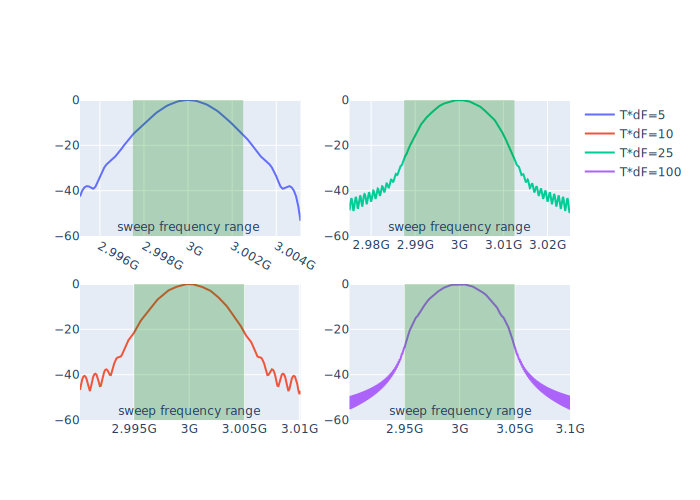

In [8]:
plot_freq_band_log([sh1, sh2, sh3, sh4], [datah1, datah2, datah3, datah4], [-60, 0])

Now the spectrum crosses the sweep frequency range at levels around -20dB. This is better then the -10dB that we have for non-weighted signal. 

## Pulse Compression, Time Side Lobes, Spectrum Ripples Impact
Another disadvantage that could have the pure LFM signal (without amplitude windowing) is the side lobes in time domain due to high spectrum ripples.
Let's first see the pulse-compression of the chirp in ideal circumstances (no added noise, the amplitude of reflected signal is the same). We will use now only one signal of 1us length and 10Mhz dF.

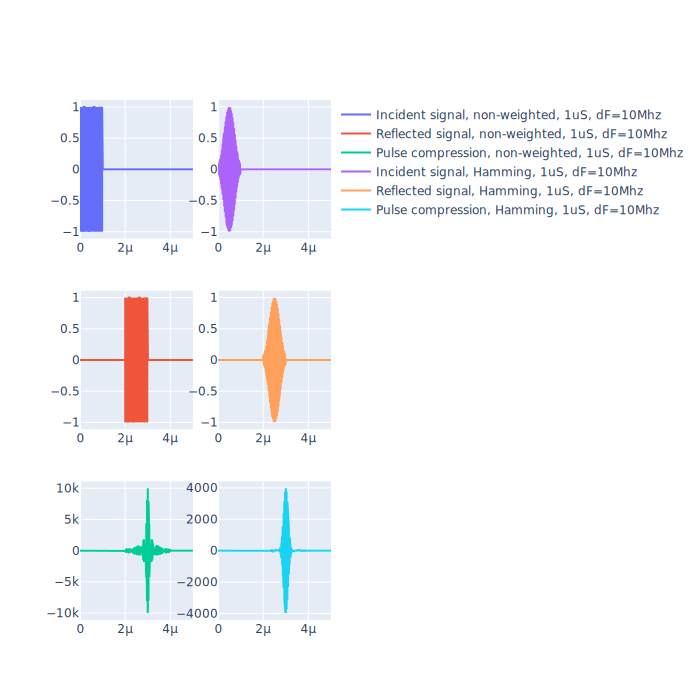

In [9]:
sim_dur = 5000*(10**(-9))
tu = 5*(10**(-11))

s_ind = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=tu,
                     l_sec=1000*(10**(-9)), s_sec=0, sim_dur=sim_dur)
reflected_signal = np.roll(s_ind.sig.data, s_ind.L * 2)
pulse_compression = np.convolve(s_ind.sig.data, np.flip(reflected_signal))

s_ind_h = pd.LfmSignal(f0=3*(10**9), delta_f=10*(10**6), tu=tu,
                       l_sec=1000*(10**(-9)), s_sec=0, sim_dur=sim_dur)
s_ind_h.sig.data[:s_ind_h.L] = np.hamming(s_ind_h.L) * s_ind_h.sig.data[:s_ind_h.L]
reflected_signal_h = np.roll(s_ind_h.sig.data, s_ind_h.L * 2)
pulse_compression_h = np.convolve(s_ind_h.sig.data, np.flip(reflected_signal_h))

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=s_ind.sig.data,
                         name=f"Incident signal, non-weighted, 1uS, dF=10Mhz"), row=1, col=1)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=reflected_signal,
                         name=f"Reflected signal, non-weighted, 1uS, dF=10Mhz"), row=2, col=1)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size),
                         y=pulse_compression[0:s_ind.sig.data.size],
                         name=f"Pulse compression, non-weighted, 1uS, dF=10Mhz"), row=3, col=1)

fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=s_ind_h.sig.data,
                         name=f"Incident signal, Hamming, 1uS, dF=10Mhz"), row=1, col=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=reflected_signal_h,
                         name=f"Reflected signal, Hamming, 1uS, dF=10Mhz"), row=2, col=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size),
                         y=pulse_compression_h[0:s_ind_h.sig.data.size],
                         name=f"Pulse compression, Hamming, 1uS, dF=10Mhz"), row=3, col=2)

fig.update_layout(hovermode='x unified', height=700)
fig.update_xaxes(exponentformat="SI")
fig.show()

Let's scale up the pulse compression results:

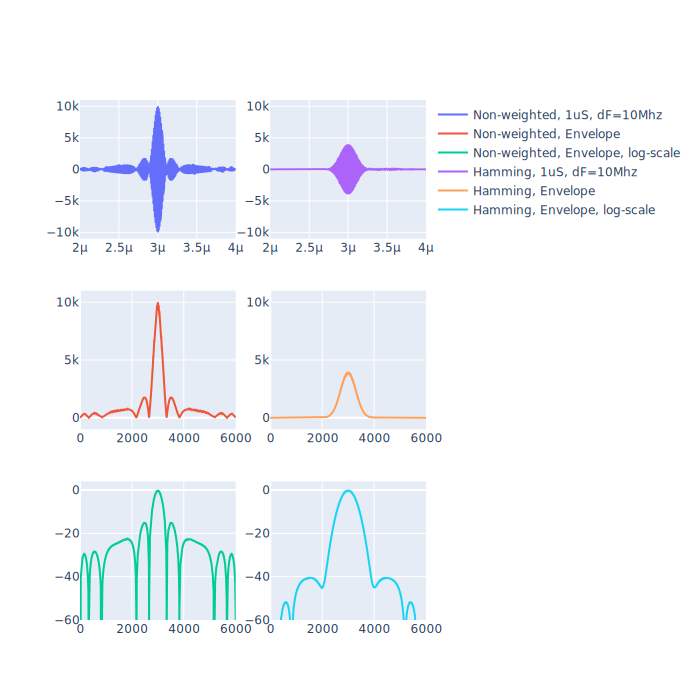

In [10]:
start = int(2*(10**(-6))/s_ind.sig.tu)
end = int(4*(10**(-6))/s_ind.sig.tu)

# idea of it is from https://stackoverflow.com/questions/34235530/how-to-get-high-and-low-envelope-of-a-signal
def get_envelope(s):
    max_ind = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1
    max_env = [s[i] for i in max_ind]
    return max_ind, max_env

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind.sig.data.size)[start:end],
                         y=pulse_compression[start:end],
                         name=f"Non-weighted, 1uS, dF=10Mhz"), row=1, col=1)
pc_envelope = get_envelope(pulse_compression[start:end])[1]
pc_envelope = [x if x > 0 else 0.000001 for x in pc_envelope]
fig.add_trace(go.Scatter(y=pc_envelope,
                         name=f"Non-weighted, Envelope"), row=2, col=1)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope/np.max(pc_envelope)),
                         name=f"Non-weighted, Envelope, log-scale"), row=3, col=1)

fig.add_trace(go.Scatter(x=np.linspace(0, sim_dur, s_ind_h.sig.data.size)[start:end],
                         y=pulse_compression_h[start:end],
                         name=f"Hamming, 1uS, dF=10Mhz"), row=1, col=2)
pc_envelope_h = get_envelope(pulse_compression_h[start:end])[1]
pc_envelope_h = [x if x > 0 else 0.000001 for x in pc_envelope_h]
fig.add_trace(go.Scatter(y=pc_envelope_h,
                         name=f"Hamming, Envelope"), row=2, col=2)
fig.add_trace(go.Scatter(y=20*np.log10(pc_envelope_h/np.max(pc_envelope_h)),
                         name=f"Hamming, Envelope, log-scale"), row=3, col=2)

fig.update_layout(hovermode='x unified', height=700)
fig.update_yaxes(range = [-11000, 11000], row=1)
fig.update_yaxes(range = [-1000, 11000], row=2)
fig.update_yaxes(range = [-60, 4], row=3)
fig.update_xaxes(exponentformat="SI")
fig.show()

You can see the ordinary linear chirp on the left and Hamming weighted to the right. The main result - Hamming decreases the absolute dynamic range and the sensitivity, but could also help a lot with reducing side lobes.

## References

1. Chirp spectrum. (2024, November 11). In *Wikipedia*. Retrieved November 11, 2024, from https://en.wikipedia.org/wiki/Chirp_spectrum
